In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, r2_score

df= pd.read_csv("./l_final.csv")

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2720 entries, 0 to 2719
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              2720 non-null   object 
 1   location             2719 non-null   object 
 2   date                 2720 non-null   object 
 3   percentage_laid_off  2720 non-null   float64
 4   industry             2718 non-null   object 
 5   source               2720 non-null   object 
 6   stage                2716 non-null   object 
 7   funds_raised         2434 non-null   float64
 8   country              2719 non-null   object 
 9   year                 2720 non-null   int64  
 10  month                2720 non-null   int64  
 11  high_layoff          2720 non-null   bool   
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 236.5+ KB


In [3]:
categorical_cols = ['company', 'location', 'industry', 'country']

def filter_unseen_categories(X_train, X_test, y_train, y_test, categorical_cols):
    mask = np.ones(len(X_test), dtype=bool)
    for col in categorical_cols:
        seen_values = set(X_train[col].unique())
        mask &= X_test[col].isin(seen_values)
    X_test_filtered = X_test[mask]
    y_test_filtered = y_test[mask]
    print(f"✅ Filtered out {len(X_test) - len(X_test_filtered)} rows with unseen categories.")
    return X_test_filtered, y_test_filtered


In [4]:
X = df.drop(columns=["source","percentage_laid_off","date","high_layoff"])
y = df["percentage_laid_off"]

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2720 entries, 0 to 2719
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company       2720 non-null   object 
 1   location      2719 non-null   object 
 2   industry      2718 non-null   object 
 3   stage         2716 non-null   object 
 4   funds_raised  2434 non-null   float64
 5   country       2719 non-null   object 
 6   year          2720 non-null   int64  
 7   month         2720 non-null   int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 170.1+ KB


In [6]:
X_train = X[X["year"].between(2020, 2022)]
X_val   = X[X["year"] == 2023]
X_test  = X[X["year"] > 2023]

In [70]:
y_train = y[X["year"].between(2020, 2022)]
y_val   = y[X["year"] == 2023]
y_test  = y[X["year"] > 2023]


In [71]:
X_val, y_val = filter_unseen_categories(X_train, X_val, y_train, y_val, categorical_cols)
X_test, y_test = filter_unseen_categories(pd.concat([X_train, X_val]), X_test,pd.concat([y_train, y_val]), y_test, categorical_cols)


✅ Filtered out 658 rows with unseen categories.
✅ Filtered out 398 rows with unseen categories.


In [72]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211 entries, 517 to 2658
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company       211 non-null    object 
 1   location      211 non-null    object 
 2   industry      211 non-null    object 
 3   stage         211 non-null    object 
 4   funds_raised  202 non-null    float64
 5   country       211 non-null    object 
 6   year          211 non-null    int64  
 7   month         211 non-null    int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 14.8+ KB


In [73]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118 entries, 0 to 2637
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company       118 non-null    object 
 1   location      118 non-null    object 
 2   industry      118 non-null    object 
 3   stage         118 non-null    object 
 4   funds_raised  112 non-null    float64
 5   country       118 non-null    object 
 6   year          118 non-null    int64  
 7   month         118 non-null    int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 8.3+ KB


In [74]:
stage_order = [
    'Seed', 'Series A', 'Series B', 'Series C', 'Series D', 'Series E',
    'Series F', 'Series G', 'Series H', 'Series I', 'Series J',
    'Post-IPO', 'Acquired', 'Private Equity', 'Subsidiary', 'Unknown'
]
ordinal_encoder = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder(categories=[stage_order])
)

cat_cols = [col for col in X.select_dtypes(include=['object']).columns if col != 'stage']
num_cols = X.select_dtypes(include=['float64', 'int64']).columns

cat_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore'))
num_transformer = make_pipeline(SimpleImputer(strategy='mean'))

preprocessor = ColumnTransformer([
    ('stage', ordinal_encoder, ['stage']),
    ('categorical', cat_transformer, cat_cols),
    ('numerical', num_transformer, num_cols)
])

In [75]:
depths = range(3,25)
mae_scores, r2_scores = [], []

print("Decision Tree Depth Tuning (Validation on 2023):\n")
for depth in depths:
    model = make_pipeline(preprocessor, DecisionTreeRegressor(max_depth=depth, random_state=42))
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)
    
    mae = mean_absolute_error(y_val, y_pred_val)
    r2 = r2_score(y_val, y_pred_val)
    
    mae_scores.append(mae)
    r2_scores.append(r2)
    
    print(f"Depth = {depth:<2} | MAE = {mae:.4f} | R² = {r2:.4f}")

best_idx = mae_scores.index(min(mae_scores))
best_depth = depths[best_idx]
print(f"\n✅ Best Depth (on Validation): {best_depth} | MAE = {mae_scores[best_idx]:.4f}, R² = {r2_scores[best_idx]:.4f}")


Decision Tree Depth Tuning (Validation on 2023):

Depth = 3  | MAE = 0.1553 | R² = 0.0585
Depth = 4  | MAE = 0.1539 | R² = 0.0436
Depth = 5  | MAE = 0.1530 | R² = 0.0513
Depth = 6  | MAE = 0.1515 | R² = 0.0498
Depth = 7  | MAE = 0.1576 | R² = -0.0031
Depth = 8  | MAE = 0.1555 | R² = 0.0011
Depth = 9  | MAE = 0.1569 | R² = -0.0373
Depth = 10 | MAE = 0.1625 | R² = -0.1538
Depth = 11 | MAE = 0.1624 | R² = -0.1923
Depth = 12 | MAE = 0.1565 | R² = -0.1528
Depth = 13 | MAE = 0.1586 | R² = -0.2159
Depth = 14 | MAE = 0.1591 | R² = -0.1695
Depth = 15 | MAE = 0.1633 | R² = -0.2573
Depth = 16 | MAE = 0.1655 | R² = -0.2850
Depth = 17 | MAE = 0.1712 | R² = -0.2759
Depth = 18 | MAE = 0.1654 | R² = -0.1717
Depth = 19 | MAE = 0.1722 | R² = -0.3116
Depth = 20 | MAE = 0.1701 | R² = -0.2957
Depth = 21 | MAE = 0.1658 | R² = -0.2269
Depth = 22 | MAE = 0.1696 | R² = -0.3086
Depth = 23 | MAE = 0.1696 | R² = -0.2932
Depth = 24 | MAE = 0.1647 | R² = -0.2355

✅ Best Depth (on Validation): 6 | MAE = 0.1515, R² =

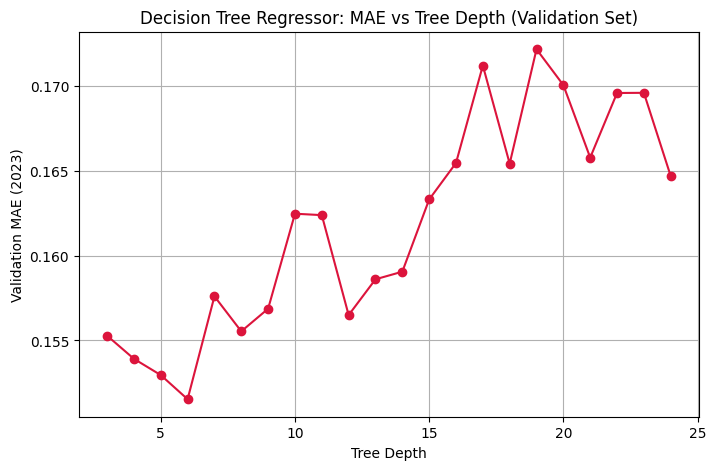

In [76]:
plt.figure(figsize=(8,5))
plt.plot(depths, mae_scores, marker='o', color='crimson')
plt.xlabel("Tree Depth")
plt.ylabel("Validation MAE (2023)")
plt.title("Decision Tree Regressor: MAE vs Tree Depth (Validation Set)")
plt.grid(True)
plt.show()

In [77]:
best_model = make_pipeline(preprocessor, DecisionTreeRegressor(max_depth=best_depth, random_state=42))
best_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))  # Train on 2020–2023
y_pred_test = best_model.predict(X_test)

mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"\n📊 Final Test Results (2024–2025): MAE = {mae_test:.4f}, R² = {r2_test:.4f}")



📊 Final Test Results (2024–2025): MAE = 0.1815, R² = 0.0050


/var/folders/8t/gkh6xnhd3lnfwhhb_pxll2bc0000gn/T/ipykernel_16765/3433273802.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices][:15],


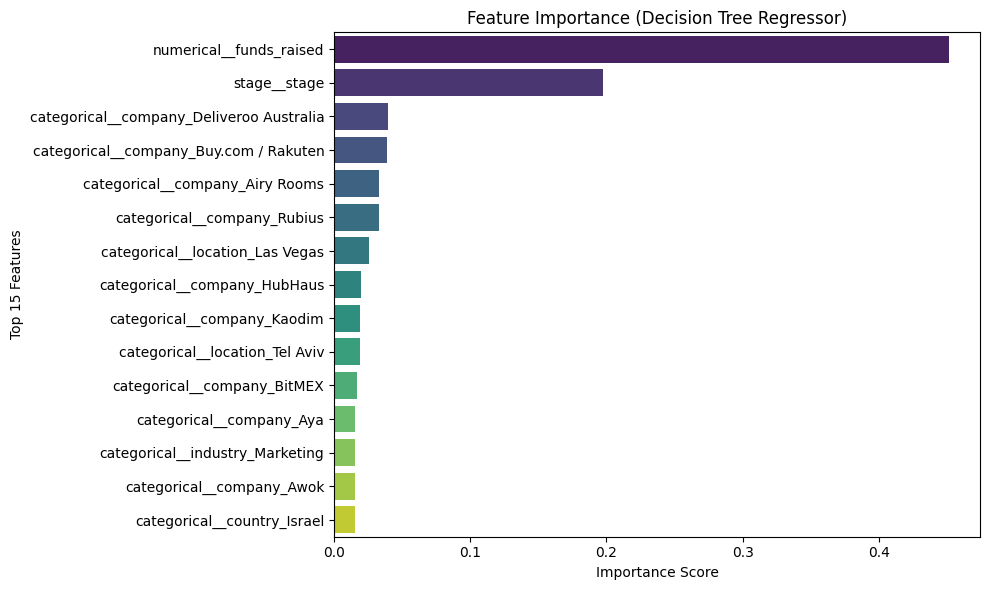

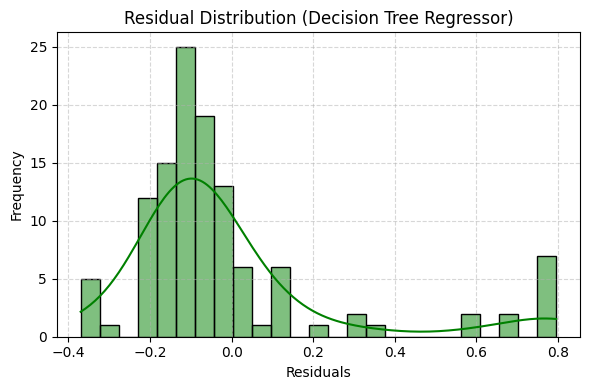

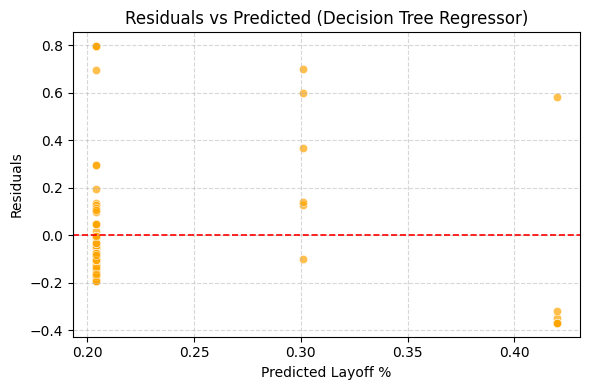

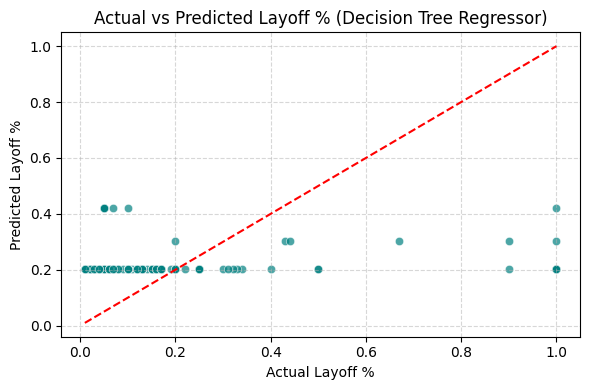

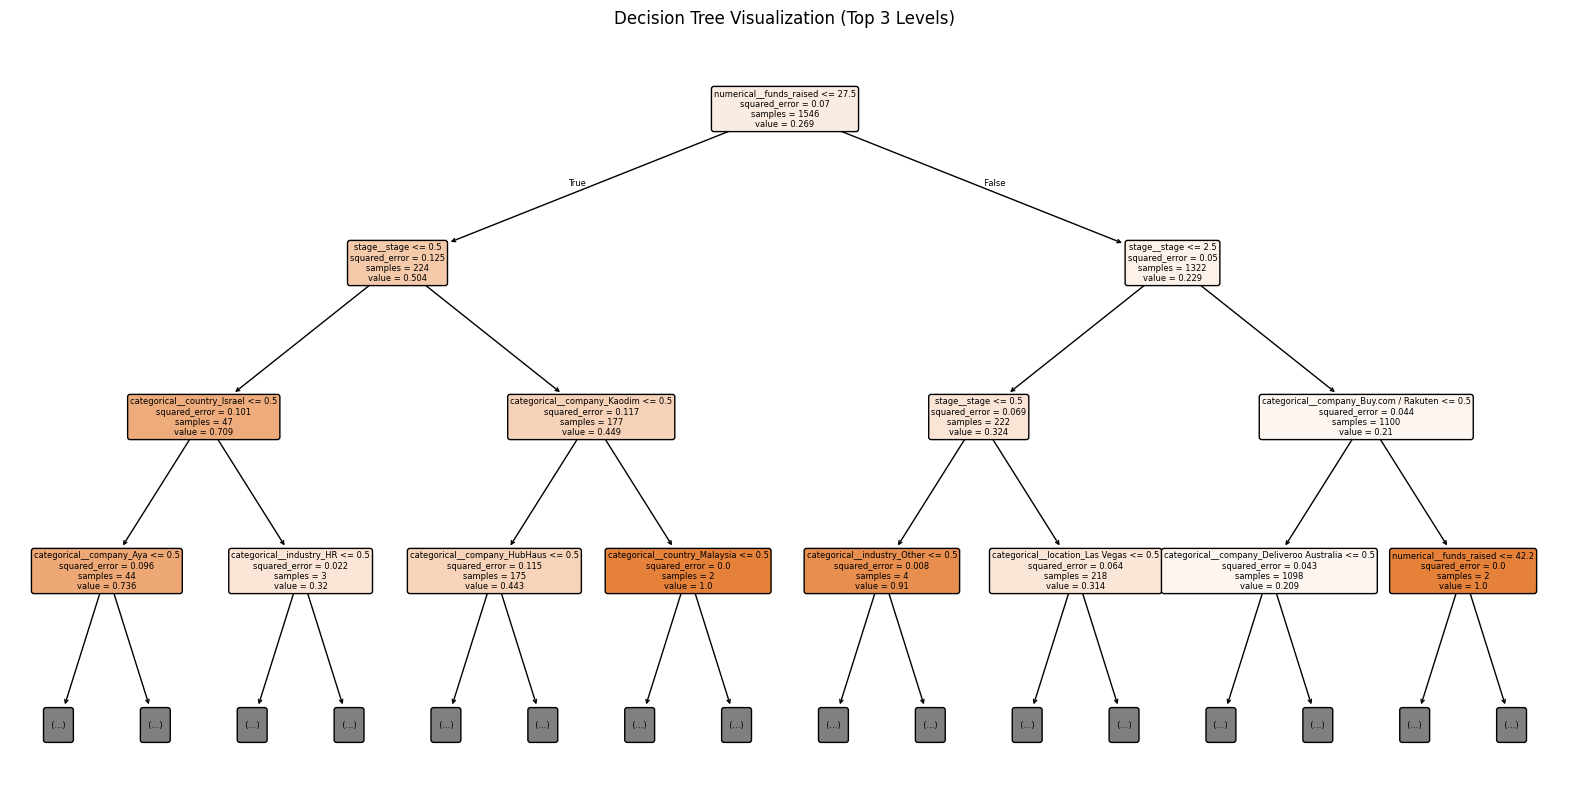

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.inspection import PartialDependenceDisplay
from sklearn import tree

# ===============================================================
# 1️⃣ FEATURE IMPORTANCE PLOT
# ===============================================================

# Extract the trained decision tree from your pipeline
tree_model = best_model.named_steps["decisiontreeregressor"]

# Extract feature names
feature_names = best_model.named_steps["columntransformer"].get_feature_names_out()
importances = tree_model.feature_importances_

# Sort by importance
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.title("Feature Importance (Decision Tree Regressor)")
sns.barplot(x=importances[indices][:15],
            y=np.array(feature_names)[indices][:15],
            palette="viridis")
plt.xlabel("Importance Score")
plt.ylabel("Top 15 Features")
plt.tight_layout()
plt.show()


# ===============================================================
# 3️⃣ RESIDUAL ANALYSIS PLOTS
# ===============================================================

residuals = y_test - y_pred_test

# Residual distribution
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, color='green', bins=25)
plt.title("Residual Distribution (Decision Tree Regressor)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Residuals vs predicted
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred_test, y=residuals, alpha=0.7, color='orange')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.2)
plt.title("Residuals vs Predicted (Decision Tree Regressor)")
plt.xlabel("Predicted Layoff %")
plt.ylabel("Residuals")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ===============================================================
# 4️⃣ ACTUAL VS PREDICTED PLOT
# ===============================================================

plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.7, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=1.5)
plt.title("Actual vs Predicted Layoff % (Decision Tree Regressor)")
plt.xlabel("Actual Layoff %")
plt.ylabel("Predicted Layoff %")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ===============================================================
# 5️⃣ DECISION TREE VISUALIZATION
# ===============================================================

plt.figure(figsize=(20,10))
tree.plot_tree(
    tree_model,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    fontsize=6,
    max_depth=3  # visualize top 3 levels for readability
)
plt.title("Decision Tree Visualization (Top 3 Levels)")
plt.show()


Random Forest Regression

In [87]:
from sklearn.ensemble import RandomForestRegressor

X = df.drop(columns=["source","percentage_laid_off","date","high_layoff"])
y = df["percentage_laid_off"]

X_train = X[X["year"].between(2020, 2023)]
X_test  = X[X["year"] > 2023]
y_train = y[X["year"].between(2020, 2023)]
y_test  = y[X["year"] > 2023]

In [88]:
categorical_cols = ['company', 'location', 'industry', 'country', 'stage']
X_test, y_test = filter_unseen_categories(X_train, X_test, y_train, y_test, categorical_cols)



✅ Filtered out 313 rows with unseen categories.


🌲 Performing Random Forest Grid Search (5-fold CV)...

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END randomforestregressor__max_depth=10, randomforestregressor__min_samples_leaf=1, randomforestregressor__min_samples_split=2, randomforestregressor__n_estimators=100; total time=   0.5s
[CV] END randomforestregressor__max_depth=10, randomforestregressor__min_samples_leaf=1, randomforestregressor__min_samples_split=2, randomforestregressor__n_estimators=100; total time=   0.6s
[CV] END randomforestregressor__max_depth=10, randomforestregressor__min_samples_leaf=1, randomforestregressor__min_samples_split=2, randomforestregressor__n_estimators=100; total time=   0.6s
[CV] END randomforestregressor__max_depth=10, randomforestregressor__min_samples_leaf=1, randomforestregressor__min_samples_split=2, randomforestregressor__n_estimators=100; total time=   0.6s
[CV] END randomforestregressor__max_depth=10, randomforestregressor__min_samples_leaf=1, randomforestregressor

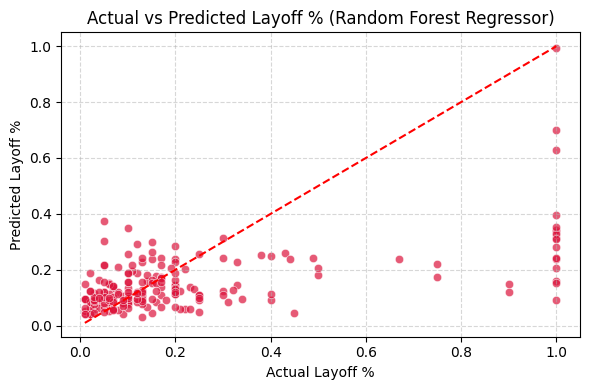

In [90]:
from sklearn.model_selection import GridSearchCV

stage_order = [[
    'Series I', 'Series J', 'Series G', 'Series F', 'Series H', 
    'Post-IPO', 'Series E', 'Private Equity', 'Series D', 'Series C',
    'Subsidiary', 'Acquired', 'Series B', 'Unknown', 'Series A', 'Seed'
]]

ordinal_col = ['stage']
cat_cols = ['company', 'location', 'industry', 'country']
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.drop(['year', 'month'], errors='ignore')

cat_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

ordinal_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder(categories=stage_order)
)

num_transformer = make_pipeline(SimpleImputer(strategy='mean'))

preprocessor = ColumnTransformer([
    ('categorical', cat_transformer, cat_cols),
    ('ordinal', ordinal_transformer, ordinal_col),
    ('numerical', num_transformer, num_cols)
])

# ============================================================
# 5️⃣ Random Forest + GridSearchCV
# ============================================================
rf_pipeline = make_pipeline(
    preprocessor,
    RandomForestRegressor(random_state=42, n_jobs=-1)
)

param_grid = {
    'randomforestregressor__n_estimators': [100, 200, 300],
    'randomforestregressor__max_depth': [10, 20, 30, None],
    'randomforestregressor__min_samples_split': [2, 5, 10],
    'randomforestregressor__min_samples_leaf': [1, 2, 4]
}

print("🌲 Performing Random Forest Grid Search (5-fold CV)...\n")

grid_search = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print(f"\n✅ Best Parameters: {grid_search.best_params_}")
print(f"✅ Best Cross-Validated MAE: {-grid_search.best_score_:.4f}")

# ============================================================
# 6️⃣ Evaluate on Test Set
# ============================================================
best_rf_model = grid_search.best_estimator_
y_pred_test = best_rf_model.predict(X_test)

mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"\n📊 Final Random Forest on Test (2024–2025):")
print(f"MAE = {mae_test:.4f}")
print(f"R²  = {r2_test:.4f}")

# ============================================================
# 7️⃣ Actual vs Predicted Plot
# ============================================================
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.7, color='crimson')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=1.5)
plt.title("Actual vs Predicted Layoff % (Random Forest Regressor)")
plt.xlabel("Actual Layoff %")
plt.ylabel("Predicted Layoff %")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [92]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2204 entries, 514 to 2719
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company       2204 non-null   object 
 1   location      2203 non-null   object 
 2   industry      2203 non-null   object 
 3   stage         2200 non-null   object 
 4   funds_raised  1978 non-null   float64
 5   country       2203 non-null   object 
 6   year          2204 non-null   int64  
 7   month         2204 non-null   int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 155.0+ KB


/var/folders/8t/gkh6xnhd3lnfwhhb_pxll2bc0000gn/T/ipykernel_16765/3348336010.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype(str).fillna("Unknown")
/var/folders/8t/gkh6xnhd3lnfwhhb_pxll2bc0000gn/T/ipykernel_16765/3348336010.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype(str).fillna("Unknown")
/var/folders/8t/gkh6xnhd3lnfwhhb_pxll2bc0000gn/T/ipykernel_16765/3348336010.py:13: SettingWithCopyWarning: 
A value is trying to be set on

0:	learn: 0.1802381	test: 0.1674593	best: 0.1674593 (0)	total: 61ms	remaining: 1m
100:	learn: 0.1303887	test: 0.1402539	best: 0.1400098 (89)	total: 262ms	remaining: 2.33s
200:	learn: 0.1129505	test: 0.1392587	best: 0.1387841 (195)	total: 471ms	remaining: 1.87s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1387840984
bestIteration = 195

Shrink model to first 196 iterations.

📊 CatBoost Performance:
MAE = 0.1388
R²  = 0.1778


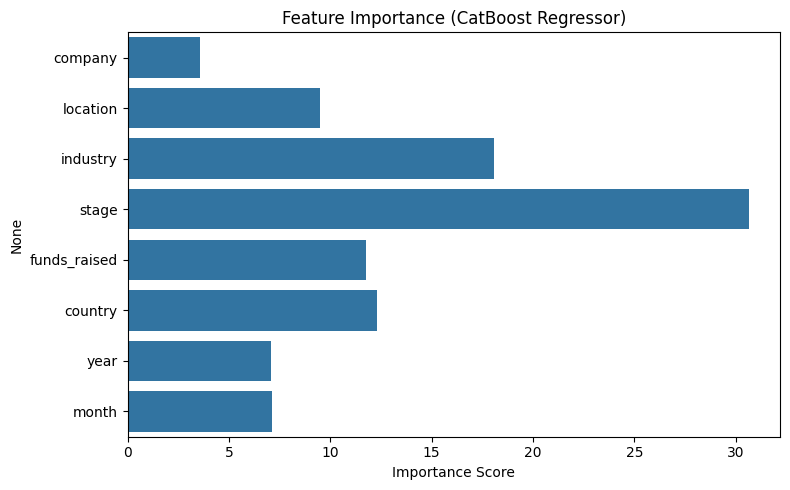

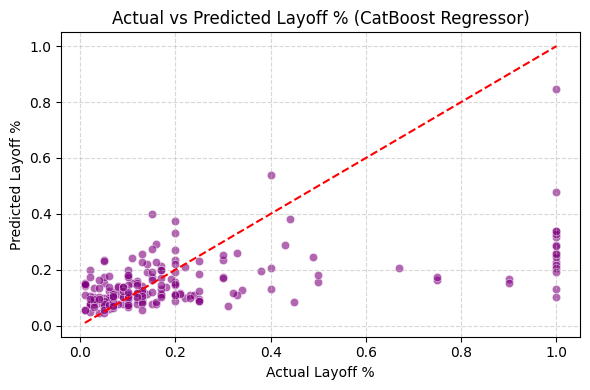

In [93]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 1️⃣ Identify categorical features
# ============================================================
categorical_cols = ['company', 'location', 'industry', 'country', 'stage']

# Convert NaN categorical values to string "Unknown"
for col in categorical_cols:
    X_train[col] = X_train[col].astype(str).fillna("Unknown")
    X_test[col] = X_test[col].astype(str).fillna("Unknown")

# Create CatBoost pools
train_pool = Pool(X_train, y_train, cat_features=categorical_cols)
test_pool = Pool(X_test, y_test, cat_features=categorical_cols)

# ============================================================
# 2️⃣ Initialize and train CatBoost model
# ============================================================
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    loss_function='MAE',
    eval_metric='MAE',
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100
)

model.fit(train_pool, eval_set=test_pool)

# ============================================================
# 3️⃣ Predictions and Evaluation
# ============================================================
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n📊 CatBoost Performance:")
print(f"MAE = {mae:.4f}")
print(f"R²  = {r2:.4f}")

# ============================================================
# 4️⃣ Feature Importance Plot
# ============================================================
plt.figure(figsize=(8,5))
sns.barplot(x=model.get_feature_importance(), y=X_train.columns)
plt.title("Feature Importance (CatBoost Regressor)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# ============================================================
# 5️⃣ Actual vs Predicted Layoff %
# ============================================================
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test, y=y_pred, color='purple', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=1.5)
plt.title("Actual vs Predicted Layoff % (CatBoost Regressor)")
plt.xlabel("Actual Layoff %")
plt.ylabel("Predicted Layoff %")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


lstm rnn 

In [14]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
X = df.drop(columns=["source","percentage_laid_off","date","high_layoff"])
y = df["percentage_laid_off"]

In [16]:
X_train = X[X["year"].between(2020, 2023)]
X_test  = X[X["year"] > 2023]
y_train = y[X["year"].between(2020, 2023)]
y_test  = y[X["year"] > 2023]

In [17]:
categorical_cols = ['company', 'location', 'industry', 'country', 'stage']
X_test, y_test = filter_unseen_categories(X_train, X_test, y_train, y_test, categorical_cols)


✅ Filtered out 313 rows with unseen categories.


In [18]:
stage_order = [[
    'Series I', 'Series J', 'Series G', 'Series F', 'Series H',
    'Post-IPO', 'Series E', 'Private Equity', 'Series D', 'Series C',
    'Subsidiary', 'Acquired', 'Series B', 'Unknown', 'Series A', 'Seed'
]]

In [19]:
ordinal_col = ['stage']
cat_cols = ['company', 'location', 'industry', 'country']
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.drop(['year','month'], errors='ignore')


In [20]:
cat_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

ordinal_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder(categories=stage_order)
)

num_transformer = make_pipeline(SimpleImputer(strategy='mean'))


In [21]:
preprocessor = ColumnTransformer([
    ('categorical', cat_transformer, cat_cols),
    ('ordinal', ordinal_transformer, ordinal_col),
    ('numerical', num_transformer, num_cols)
])

🚀 Performing XGBoost Grid Search (5-fold CV)...

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__gamma=0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=4, xgbregressor__n_estimators=200, xgbregressor__reg_lambda=1, xgbregressor__subsample=0.8; total time=   0.2s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__gamma=0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=4, xgbregressor__n_estimators=200, xgbregressor__reg_lambda=1, xgbregressor__subsample=0.8; total time=   0.2s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__gamma=0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=4, xgbregressor__n_estimators=200, xgbregressor__reg_lambda=1, xgbregressor__subsample=1.0; total time=   0.2s
[CV] END xgbregressor__colsample_bytree=0.8, xgbregressor__gamma=0, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=4, xgbregressor__n_estimators=200, xgbregressor__r

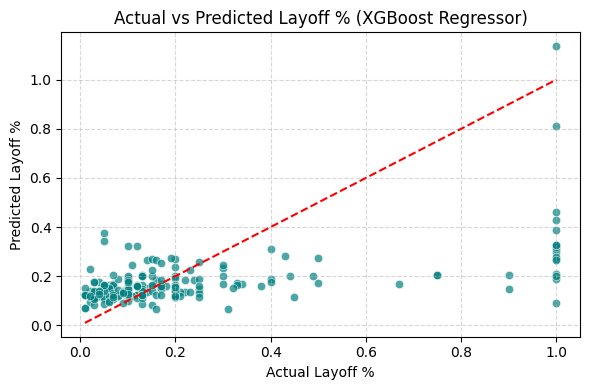

In [22]:
xgb_pipeline = make_pipeline(
    preprocessor,
    XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
)
param_grid_xgb = {
    'xgbregressor__n_estimators': [200, 400, 600],
    'xgbregressor__max_depth': [4, 6, 8],
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1],
    'xgbregressor__subsample': [0.8, 1.0],
    'xgbregressor__colsample_bytree': [0.8, 1.0],
    'xgbregressor__reg_lambda': [1, 3, 5],
    'xgbregressor__gamma': [0, 0.1, 0.3]
}
print("🚀 Performing XGBoost Grid Search (5-fold CV)...\n")

grid_xgb = GridSearchCV(
    xgb_pipeline,
    param_grid=param_grid_xgb,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_xgb.fit(X_train, y_train)

print(f"\n✅ Best Parameters: {grid_xgb.best_params_}")
print(f"✅ Best Cross-Validated MAE: {-grid_xgb.best_score_:.4f}")

# ============================================================
# 4️⃣ Evaluate on Test Set
# ============================================================
best_xgb_model = grid_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"\n📊 Final XGBoost on Test (2024–2025):")
print(f"MAE = {mae_xgb:.4f}")
print(f"R²  = {r2_xgb:.4f}")

plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.7, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=1.5)
plt.title("Actual vs Predicted Layoff % (XGBoost Regressor)")
plt.xlabel("Actual Layoff %")
plt.ylabel("Predicted Layoff %")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/var/folders/8t/gkh6xnhd3lnfwhhb_pxll2bc0000gn/T/ipykernel_2737/1937628096.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="Feature", x="Importance", data=fi_df.head(15), palette="viridis")


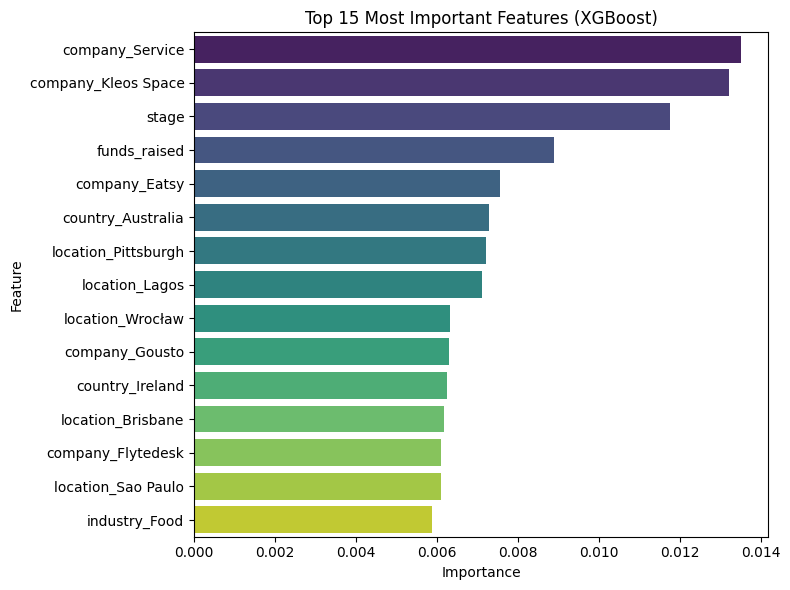

In [23]:
# ============================================================
# 6️⃣ Feature Importance (Gain-based)
# ============================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract trained booster
booster = best_xgb_model.named_steps['xgbregressor']

# Get feature names from preprocessing
ohe = best_xgb_model.named_steps['columntransformer'].named_transformers_['categorical'].named_steps['onehotencoder']
ohe_feature_names = list(ohe.get_feature_names_out(cat_cols))
feature_names = ohe_feature_names + ordinal_col + list(num_cols)

# Feature importance dataframe
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": booster.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(y="Feature", x="Importance", data=fi_df.head(15), palette="viridis")
plt.title("Top 15 Most Important Features (XGBoost)")
plt.tight_layout()
plt.show()
